In [1]:
import pickle 

with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from msresist.figures.figureM3 import build_pval_matrix, calculate_mannW_pvals, plot_clusters_binaryfeatures
from msresist.figures.figure3 import plotPCA, plotMotifs, plotUpstreamKinase_heatmap
from msresist.logistic_regression import plotROC, plotClusterCoefficients


X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers = pd.DataFrame(model.transform()).T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T
centers.columns = np.arange(model.ncl) + 1
centers["Patient_ID"] = X.columns[4:]
centers = centers.loc[~centers["Patient_ID"].str.endswith(".N"), :].sort_values(by="Patient_ID").set_index("Patient_ID")

# Import Cold-Hot Tumor data
y = pd.read_csv("msresist/data/MS/CPTAC/Hot_Cold.csv").dropna(axis=1).sort_values(by="Sample ID")
y = y.loc[~y["Sample ID"].str.endswith(".N"), :].set_index("Sample ID")
l1 = list(centers.index)
l2 = list(y.index)
dif = [i for i in l1 + l2 if i not in l1 or i not in l2]
centers = centers.drop(dif)

# Transform to binary
y = y.replace("Cold-tumor enriched", 0)
y = y.replace("Hot-tumor enriched", 1)
y = np.squeeze(y)

# Remove NAT-enriched samples
centers = centers.drop(y[y=="NAT enriched"].index)
y = y.drop(y[y=="NAT enriched"].index).astype(int)
assert all(centers.index.values == y.index.values), "Samples don't match"

centers["HCT"] = y.values

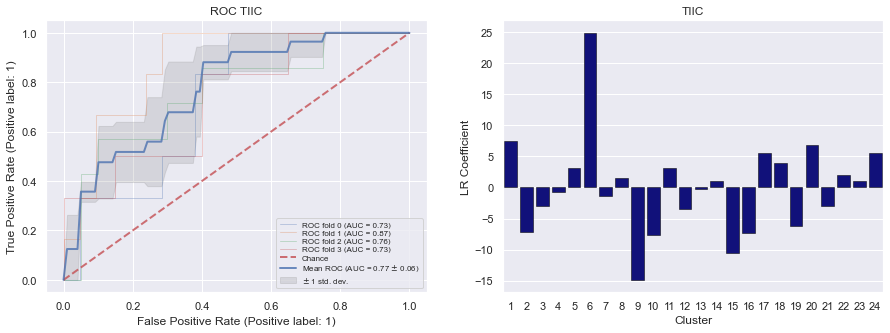

In [25]:
lr = LogisticRegressionCV(cv=7, solver="saga", max_iter=100000, n_jobs=-1, penalty="elasticnet", class_weight="balanced", l1_ratios=[0.4, 0.9], tol=1e-8)

_, ax = plt.subplots(1, 2, figsize=(15, 5))

plotROC(ax[0], lr, centers.iloc[:, :-1].values, y, cv_folds=4, title="ROC TIIC")
plotClusterCoefficients(ax[1], lr.fit(centers.iloc[:, :-1], y.values), title="TIIC")